In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.io import fits
from astropy.wcs import WCS
from scipy.spatial import KDTree
from matplotlib import colors
import yaml

np.warnings.filterwarnings('ignore')

In [2]:
# Custom code to load .list files
import stuff

# Auto Photometry, bands R, G and I

## Configuration

In [3]:
print(open('/home/aalvarez/Work/Data/sim08/test_multiframe.config').read())

measurement-config-file=/home/aalvarez/Work/Data/sim08/config.yaml
output-properties=WorldCentroid,PixelCentroid,SourceIDs,SourceFlags,AutoPhotometry,AperturePhotometry
#,MultiframeModelFitting
detection-image=/home/aalvarez/Work/Data/sim08/sim08.fits
weight-image=/home/aalvarez/Work/Data/sim08/sim08.weight.fits
weight-type=weight
detection-image-saturation=59000
detection-image-gain=1
detect-minarea=10
partition-min-area=10
threads-nb=4
cellsize-value=32
partition-multithreshold=true
grouping-algorithm=SPLIT
checkimage-residual=/home/aalvarez/Work/Data/sim08/mci_residual.fits
checkimage-modelfitting=/home/aalvarez/Work/Data/sim08/mci_modelfitting.fits
checkimage-background=/home/aalvarez/Work/Data/sim08/mci_background.fits
checkimage-variance=/home/aalvarez/Work/Data/sim08/mci_variance.fits
checkimage-segmentation=/home/aalvarez/Work/Data/sim08/mci_segmentation.fits
checkimage-partition=/home/aalvarez/Work/Data/sim08/mci_partition.fits
checkimage-filtered=/home/aalvarez/Work/Data/sim0

In [4]:
multiframe_config = yaml.load(open('/home/aalvarez/Work/Data/sim08/config.yaml'))
print(yaml.dump(multiframe_config))

- measurements-group:
    image-files:
    - {path: /home/aalvarez/Work/Data/sim08/sim08_g_*.fits, psf-path: /home/aalvarez/Work/Data/sim08/sim08_g_*.psf}
    name: g
- measurements-group:
    image-files:
    - {path: /home/aalvarez/Work/Data/sim08/sim08_r_*.fits, psf-path: /home/aalvarez/Work/Data/sim08/sim08_r_*.psf}
    name: r
- measurements-group:
    image-files:
    - {path: /home/aalvarez/Work/Data/sim08/sim08_i_*.fits, psf-path: /home/aalvarez/Work/Data/sim08/sim08_i_*.psf}
    name: i



## Load simulation data

In [5]:
r_stars, r_galaxies = stuff.parse_stuff_list('/home/aalvarez/Work/Data/sim08/sim08_r.list')
g_stars, g_galaxies = stuff.parse_stuff_list('/home/aalvarez/Work/Data/sim08/sim08_g.list')
i_stars, i_galaxies = stuff.parse_stuff_list('/home/aalvarez/Work/Data/sim08/sim08_i.list')

## Display coadded image

In [6]:
coadd_img = fits.open('/home/aalvarez/Work/Data/sim08/sim08.fits')[0]
coadd_img_i = fits.open('/home/aalvarez/Work/Data/sim08/sim08_i.fits')[0]
aperture_img = fits.open('/home/aalvarez/Work/Data/sim08/mci_auto.fits')[0]

Text(0.5,1,'Coadded image')

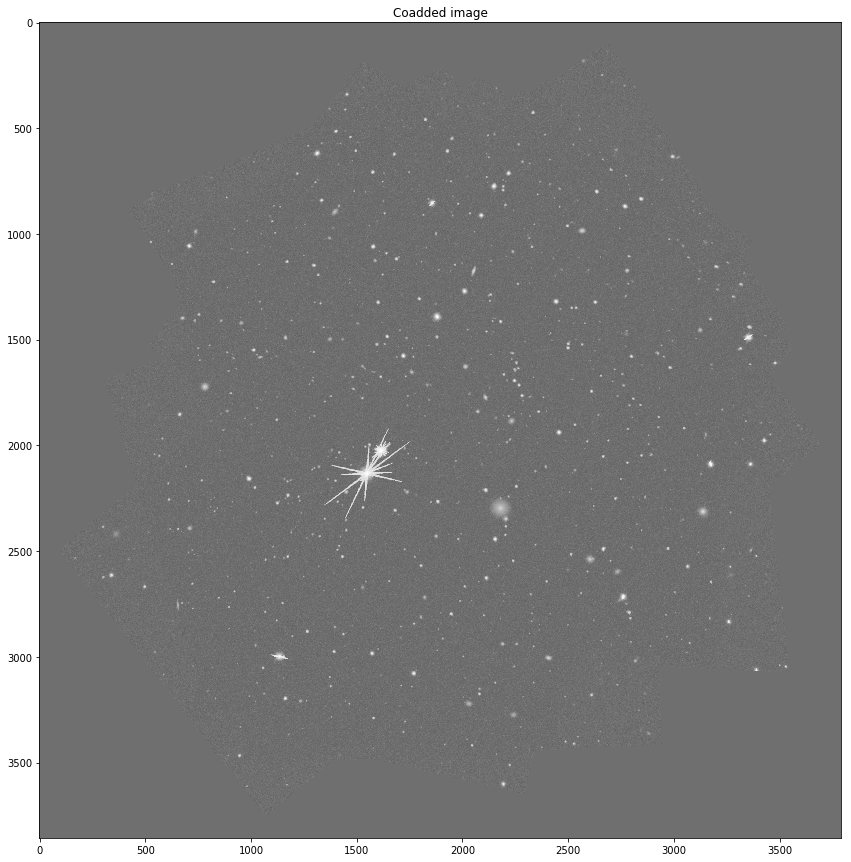

In [7]:
plt.figure(figsize=(15,15))
plt.imshow(coadd_img.data, norm=colors.SymLogNorm(5), cmap=plt.get_cmap('Greys_r'))
plt.title('Coadded image')

### Build a KDTree with the source coordinates

In [8]:
# We imagine the coordinates are the same for all simulations!
assert(np.all(r_stars.ra == g_stars.ra) and np.all(r_stars.dec == g_stars.dec))
assert(np.all(r_galaxies.ra == g_galaxies.ra) and np.all(r_galaxies.dec == g_galaxies.dec))
assert(np.all(r_galaxies.ra == i_galaxies.ra) and np.all(r_galaxies.dec == i_galaxies.dec))

stars_coords = np.stack([r_stars.ra, r_stars.dec]).T
galaxies_coords = np.stack([r_galaxies.ra, r_galaxies.dec]).T
all_coords = np.append(stars_coords, galaxies_coords, axis=0)
all_kdtree = KDTree(all_coords)
r_mags = np.append(r_stars.mag, r_galaxies.mag)
g_mags = np.append(g_stars.mag, g_galaxies.mag)
i_mags = np.append(i_stars.mag, i_galaxies.mag)

n_stars = len(r_stars)
n_galaxies = len(r_galaxies)

### Load the output catalog

In [9]:
output_catalog = Table.read('/home/aalvarez/Work/Data/sim08/multiframe_output.fits')

Compute average magnitudes

In [10]:
# This comes from sim09_*_sky.conf
mag_zeropoint = 26.
exp_time = 300.

In [11]:
for i in range(10):
    for b in ['r', 'g', 'i']:
        auto_mag_cname = f'auto_mag_{b}_{i}'
        flux_cname = f'auto_flux_{b}_{i}'
        mag_cname = f'mag_{b}_{i}'
        output_catalog[auto_mag_cname][output_catalog[auto_mag_cname] >= 99.] = np.nan
        output_catalog[flux_cname][output_catalog[flux_cname] == 0.] = np.nan
        output_catalog[mag_cname] = mag_zeropoint - 2.5 * np.log10(output_catalog[flux_cname] / exp_time)

In [12]:
for b in ['r', 'g', 'i']:
    output_catalog[f'auto_flux_{b}'] = np.nanmean(np.array([output_catalog[f'auto_flux_{b}_{i}'] for i in range(10)]), axis=0)
    output_catalog[f'{b}_mag'] = np.nanmean(np.array([output_catalog[f'mag_{b}_{i}'] for i in range(10)]), axis=0)
    output_catalog[f'{b}_mag_med'] = np.nanmedian(np.array([output_catalog[f'mag_{b}_{i}'] for i in range(10)]), axis=0)
    output_catalog[f'{b}_mag_max'] = np.nanmax(np.array([output_catalog[f'mag_{b}_{i}'] for i in range(10)]), axis=0) - output_catalog[f'{b}_mag']
    output_catalog[f'{b}_mag_min'] = output_catalog[f'{b}_mag'] - np.nanmin(np.array([output_catalog[f'mag_{b}_{i}'] for i in range(10)]), axis=0)

### Compare results

In [13]:
def get_closest(catalog):
    distances = []
    index_c = []
    index_s = []
    for i, e in enumerate(catalog):
        d, s = all_kdtree.query([e['world_centroid_alpha'], e['world_centroid_delta']], 1)
        distances.append(d)
        index_c.append(i)
        index_s.append(s)
    return {
        'dist': np.array(distances),
        'catalog': np.array(index_c),
        'source': np.array(index_s),
    }

In [14]:
closest = get_closest(output_catalog)

In [15]:
print("Number of sources found:", len(closest['dist']))

Number of sources found: 1443


In [16]:
def plot_stats(ax, data):
    ax.text(
        0.7, 0.7,
        '$\mu$: {:.3e}\n$\sigma$: {:.3e}\n$\%_{{50}}$: {:.3e}'.format(
            np.average(data),
            np.std(data),
            np.median(data),
        ),
        transform=ax.transAxes
    )

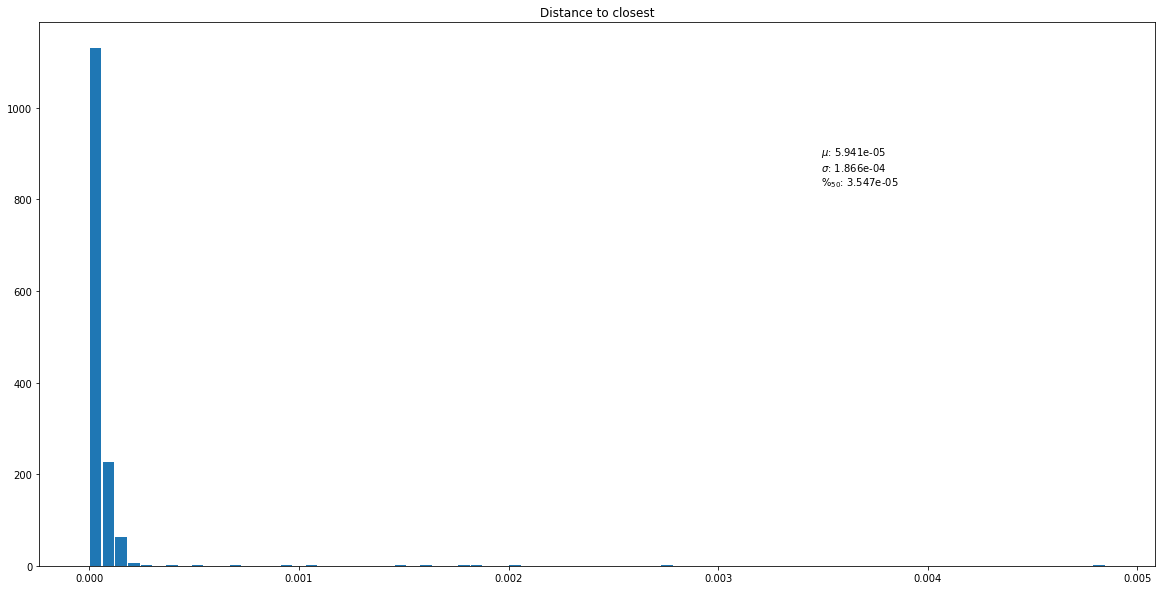

In [17]:
plt.figure(figsize=(20, 10))
ax1 = plt.subplot(1, 1, 1)
ax1.hist(closest['dist'], 80, rwidth=0.9)
plot_stats(ax1, closest['dist'])
_ = ax1.set_title('Distance to closest')

### Magnitudes

In [18]:
r_mag_diff = output_catalog[closest['catalog']]['r_mag'] - r_mags[closest['source']]
g_mag_diff = output_catalog[closest['catalog']]['r_mag'] - g_mags[closest['source']]
i_mag_diff = output_catalog[closest['catalog']]['i_mag'] - i_mags[closest['source']]

r_mag_med_diff = output_catalog[closest['catalog']]['r_mag_med'] - r_mags[closest['source']]
g_mag_med_diff = output_catalog[closest['catalog']]['r_mag_med'] - g_mags[closest['source']]
i_mag_med_diff = output_catalog[closest['catalog']]['i_mag_med'] - i_mags[closest['source']]

# Filter NaN and outliers
r_not_nan = (np.isnan(r_mag_diff) == False)
g_not_nan = (np.isnan(g_mag_diff) == False)
i_not_nan = (np.isnan(i_mag_diff) == False)
r_outlier_filter = (r_mag_diff >= np.percentile(r_mag_diff[r_not_nan], 5)) & (r_mag_diff <= np.percentile(r_mag_diff[r_not_nan], 95)) & r_not_nan
g_outlier_filter = (g_mag_diff >= np.percentile(g_mag_diff[g_not_nan], 5)) & (g_mag_diff <= np.percentile(g_mag_diff[g_not_nan], 95)) & g_not_nan
i_outlier_filter = (i_mag_diff >= np.percentile(i_mag_diff[i_not_nan], 5)) & (i_mag_diff <= np.percentile(i_mag_diff[i_not_nan], 95)) & i_not_nan

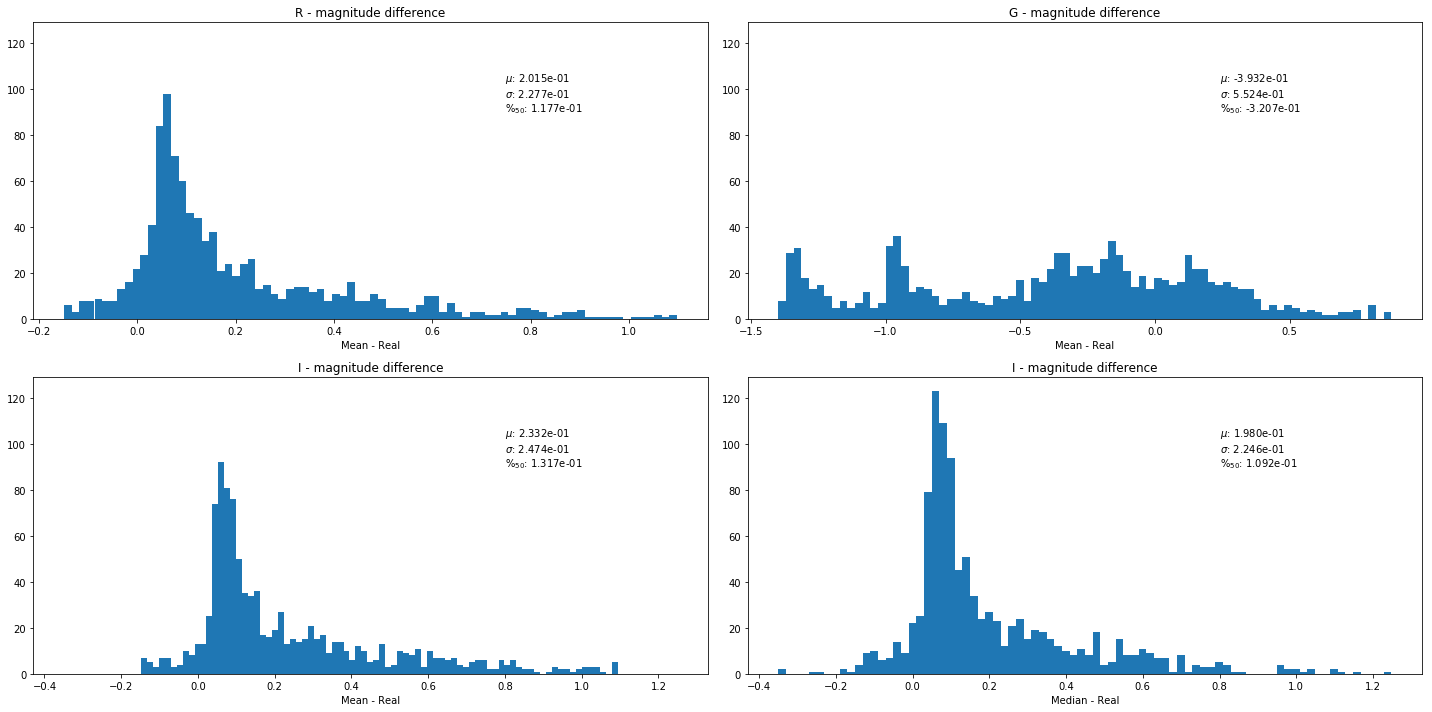

In [19]:
plt.figure(figsize=(20, 10))

ax1 = plt.subplot(2, 2, 1)
ax1.hist(r_mag_diff[r_outlier_filter], 80)
ax1.set_xlabel('Mean - Real')
plot_stats(ax1, r_mag_diff[r_outlier_filter])
ax1.set_title('R - magnitude difference')

ax2 = plt.subplot(2, 2, 2, sharey=ax1)
ax2.hist(g_mag_diff[g_outlier_filter], 80)
ax2.set_xlabel('Mean - Real')
plot_stats(ax2, g_mag_diff[g_outlier_filter])
_ = ax2.set_title('G - magnitude difference')

ax3 = plt.subplot(2, 2, 3, sharey=ax1)
ax3.hist(i_mag_diff[i_outlier_filter], 80)
ax3.set_xlabel('Mean - Real')
plot_stats(ax3, i_mag_diff[i_outlier_filter])
_ = ax3.set_title('I - magnitude difference')

ax4 = plt.subplot(2, 2, 4, sharey=ax1, sharex=ax3)
ax4.hist(i_mag_med_diff[i_outlier_filter], 80)
ax4.set_xlabel('Median - Real')
plot_stats(ax4, i_mag_med_diff[i_outlier_filter])
_ = ax4.set_title('I - magnitude difference')

plt.tight_layout()

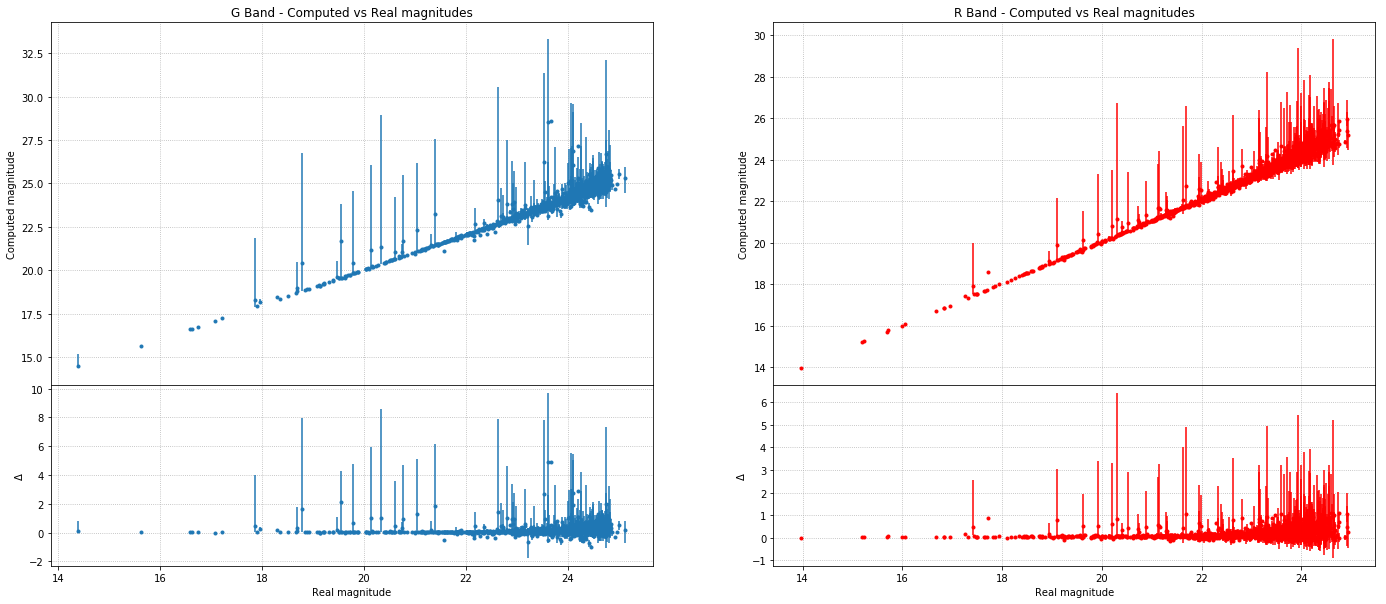

In [20]:
plt.figure(figsize=(20, 10))
plt.subplots_adjust(left=0.07, right=0.99, hspace=0.0, wspace=0.2)

ax1 = plt.subplot2grid((3, 2), (0, 0), 2)
ax1.errorbar(
    g_mags[closest['source']][g_outlier_filter],
    output_catalog[closest['catalog']]['g_mag'][g_outlier_filter],
    yerr=[
        output_catalog[closest['catalog']]['g_mag_min'][g_outlier_filter],
        output_catalog[closest['catalog']]['g_mag_max'][g_outlier_filter]
    ],
    fmt='.'
)
ax1.set_ylabel('Computed magnitude')
ax1.set_xlabel('Real magnitude')
ax1.grid(True, linestyle=':')
ax1.set_title('G Band - Computed vs Real magnitudes')

ax2 = plt.subplot2grid((3, 2), (2, 0), 1)
ax2.errorbar(
    g_mags[closest['source']][g_outlier_filter],
    (output_catalog[closest['catalog']]['g_mag'] - g_mags[closest['source']])[g_outlier_filter],
    yerr=[
        output_catalog[closest['catalog']]['g_mag_min'][g_outlier_filter],
        output_catalog[closest['catalog']]['g_mag_max'][g_outlier_filter]
    ],
    fmt='.'
)
ax2.set_ylabel('$\Delta$')
ax2.set_xlabel('Real magnitude')
ax2.grid(True, linestyle=':')

ax3 = plt.subplot2grid((3, 2), (0, 1), 2)
ax3.errorbar(
    r_mags[closest['source']][r_outlier_filter],
    output_catalog[closest['catalog']]['r_mag'][r_outlier_filter],
    yerr=[
        output_catalog[closest['catalog']]['r_mag_min'][r_outlier_filter],
        output_catalog[closest['catalog']]['r_mag_max'][r_outlier_filter]
    ],
    fmt='.', c='red'
)
ax3.set_ylabel('Computed magnitude')
ax3.set_xlabel('Real magnitude')
ax3.grid(True, linestyle=':')
ax3.set_title('R Band - Computed vs Real magnitudes')

ax4 = plt.subplot2grid((3, 2), (2, 1), 1)
ax4.errorbar(
    r_mags[closest['source']][r_outlier_filter],
    (output_catalog[closest['catalog']]['r_mag'] - r_mags[closest['source']])[r_outlier_filter],
    yerr=[
        output_catalog[closest['catalog']]['r_mag_min'][r_outlier_filter],
        output_catalog[closest['catalog']]['r_mag_max'][r_outlier_filter]
    ],
    fmt='.', c='red'
)
ax4.set_ylabel('$\Delta$')
ax4.set_xlabel('Real magnitude')
ax4.grid(True, linestyle=':')

_ = 0

In [21]:
saturated_flag = (output_catalog[closest['catalog']]['source_flags'] & 4).sum(axis=1).astype(np.bool)
auto_flag = (output_catalog[closest['catalog']]['auto_flags'])[:,1].astype(np.bool)
i_mark = auto_flag | saturated_flag | border_flag
i_mark.sum()

NameError: name 'border_flag' is not defined

In [ ]:
plt.figure(figsize=(20, 10))
plt.subplots_adjust(left=0.07, right=0.99, hspace=0.0, wspace=0.2)

ax1 = plt.subplot2grid((3, 2), (0, 0), 2)
ax1.scatter(
    i_mags[closest['source']][i_outlier_filter],
    output_catalog[closest['catalog']]['i_mag'][i_outlier_filter],
    marker='.'
)
ax1.scatter(
    i_mags[closest['source']][(i_outlier_filter & i_mark)],
    output_catalog[closest['catalog']]['i_mag'][i_outlier_filter & i_mark],
    marker='.', c='orange'
)
ax1.set_ylabel('Computed magnitude (mean)')
ax1.set_xlabel('Real magnitude')
ax1.grid(True, linestyle=':')
ax1.set_title('I Band - Average vs Real magnitudes')

ax2 = plt.subplot2grid((3, 2), (2, 0), 1)
ax2.scatter(
    i_mags[closest['source']][i_outlier_filter],
    (output_catalog[closest['catalog']]['i_mag'] - i_mags[closest['source']])[i_outlier_filter],
    marker='.'
)
ax2.scatter(
    i_mags[closest['source']][i_outlier_filter & i_mark],
    (output_catalog[closest['catalog']]['i_mag'] - i_mags[closest['source']])[i_outlier_filter & i_mark],
    marker='.', c='orange'
)
ax2.set_ylabel('$\Delta$')
ax2.set_xlabel('Real magnitude')
ax2.grid(True, linestyle=':')

ax3 = plt.subplot2grid((3, 2), (0, 1), 2, sharey=ax1)
ax3.scatter(
    i_mags[closest['source']][i_outlier_filter],
    output_catalog[closest['catalog']]['i_mag_med'][i_outlier_filter],
    marker='.'
)
ax3.scatter(
    i_mags[closest['source']][(i_outlier_filter & i_mark)],
    output_catalog[closest['catalog']]['i_mag_med'][i_outlier_filter & i_mark],
    marker='.', c='orange'
)
ax3.set_ylabel('Computed magnitude (median)')
ax3.set_xlabel('Real magnitude')
ax3.grid(True, linestyle=':')
ax3.set_title('I Band - Median vs Real magnitudes')

ax4 = plt.subplot2grid((3, 2), (2, 1), 1, sharey=ax2)
ax4.scatter(
    i_mags[closest['source']][i_outlier_filter],
    (output_catalog[closest['catalog']]['i_mag_med'] - i_mags[closest['source']])[i_outlier_filter],
    marker='.'
)
ax4.scatter(
    i_mags[closest['source']][i_outlier_filter & i_mark],
    (output_catalog[closest['catalog']]['i_mag_med'] - i_mags[closest['source']])[i_outlier_filter & i_mark],
    marker='.', c='orange'
)
ax4.set_ylabel('$\Delta$')
ax4.set_xlabel('Real magnitude')
ax4.grid(True, linestyle=':')

### Figure out who are those outliers

In [ ]:
# Display non flagged sources with a big error
big_error = (np.abs(i_mag_med_diff) > 2) & ~i_mark

flux_overestimated = i_mag_diff < 0
flux_underestimated = i_mag_diff > 0

In [ ]:
output_catalog[big_error][['source_id', 'pixel_centroid_x', 'pixel_centroid_y', 'auto_flags'] + [f'auto_flux_i_{i}' for i in range(10)]]

In [ ]:
some_id = (aperture_img.data > 0).astype(np.float)
aperture_mask = np.ones(aperture_img.shape + (4,))
aperture_mask[:,:,0] = some_id
aperture_mask[:,:,1] = some_id * 0.5
aperture_mask[:,:,2] = some_id * 0.5
aperture_mask[:,:,3] = some_id * 0.4

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(coadd_img_i.data, norm=colors.SymLogNorm(50), cmap=plt.get_cmap('Greys_r'))
plt.imshow(aperture_mask)
plt.scatter(
    output_catalog[big_error & flux_overestimated]['pixel_centroid_x'],
    output_catalog[big_error & flux_overestimated]['pixel_centroid_y'],
    marker='*', c='red'
)
plt.scatter(
    output_catalog[big_error & flux_underestimated]['pixel_centroid_x'],
    output_catalog[big_error & flux_underestimated]['pixel_centroid_y'],
    marker='*', c='blue'
)

There are a few sources that are outside i. They will not be flagged as "boundary" because they are not on the boundary on the detection image. When they are fully out, the flux will be nan for all frames, but in this cases they are close enough to just touch a few pixels, so they end having a value that is wildly off.